# Importaciones

In [1]:
"""
Full demo script exercising all components of the Trading Environment repo.
"""
from trading_lib.imports import *
from trading_lib.trading_environment import (
    DataManager, RiskManager, PerformanceAnalyzer, Optimizer,
    ReportManager, TradingSystem, StrategyManager, StrategyCollection,
    DATA_DIR, MAX_FILE_SIZE
)
from trading_lib.strategies import (
    MovingAverageCrossStrategy, DcaStrategy, DonchianBreakoutStrategy,
    ADXTrendStrategy, ROCStrategy, MACDStrategy, BollingerMeanRevStrategy,
    RSIStrategy, PairTradingStrategy, VWAPStrategy
)

# Tests

In [2]:
# 1) Load data
dm = DataManager(DATA_DIR, MAX_FILE_SIZE)
data = dm.load_data(symbols='BTC-USD', period='2y', interval='1d')
print("Data loaded shape:", data.shape)

Data loaded shape: (732, 6)


In [3]:
# 2) RiskManager Demo
price = data['close'].iloc[-1]
rm_pct = RiskManager(method='pct', risk_pct=0.02)
print("Pct size:", rm_pct.calculate_size(10000, price, data))
rm_atr = RiskManager(method='atr', risk_pct=0.01, atr_window=14)
print("ATR size:", rm_atr.calculate_size(10000, price, data, stop_loss=price*0.95))

Pct size: 0.0018765713077671506
ATR size: 0.018765713077671487


In [4]:
# 3) Strategy Demo
strat = MovingAverageCrossStrategy({'short_window':10, 'long_window':20})
sig = strat.generate_signals(data)
print("Signal counts:", sig.value_counts().to_dict())
eq = strat.backtest(data, initial_capital=10000, transaction_cost=0.001)
pa = PerformanceAnalyzer(eq, strat.returns)
print("MA Crossover Performance:\n", pa.summary())

Signal counts: {0: 696, 1: 18, -1: 18}
MA Crossover Performance:
 Total Return    -0.006043
Ann. Return     -0.002084
Ann. Vol         0.068671
Sharpe           0.003787
Max Drawdown    -0.081468
Win Rate         0.017760
Profit Factor    1.002707
Expectancy      -0.004426
dtype: float64


In [5]:
# 4) Optimizer Demo (Grid, Bayes, DE)
print("\n=== Optimizer Demo ===")
subset = [MovingAverageCrossStrategy, MACDStrategy]
# Grid Search
print("-- Grid Search --")
best_strat_g, best_params_g, perf_g, eq_g = Optimizer.find_best_strategy(
    subset, data, method='grid', metric='Sharpe'
)
print(f"Grid best: {best_strat_g.name} {best_params_g}")
# Bayesian Search
print("-- Bayesian Search --")
best_strat_b, best_params_b, perf_b, eq_b = Optimizer.find_best_strategy(
    subset, data, method='bayes', metric='Sharpe', n_trials=10, seed=123
)
print(f"Bayes best: {best_strat_b.name} {best_params_b}")
# Differential Evolution
print("-- DE Search --")
best_strat_d, best_params_d, perf_d, eq_d = Optimizer.find_best_strategy(
    subset, data, method='de', metric='Sharpe', maxiter=5, popsize=5
)
print(f"DE best: {best_strat_d.name} {best_params_d}")


=== Optimizer Demo ===
-- Grid Search --
Grid best: MACD 5/100/7 {'fast': 5, 'slow': 100, 'signal': 7}
-- Bayesian Search --
Bayes best: MACD 12/25/15 {'fast': 12, 'slow': 25, 'signal': 15}
-- DE Search --
DE best: MACD 16/63/29 {'fast': 16, 'slow': 63, 'signal': 29}


Plotting metrics for Grid best...


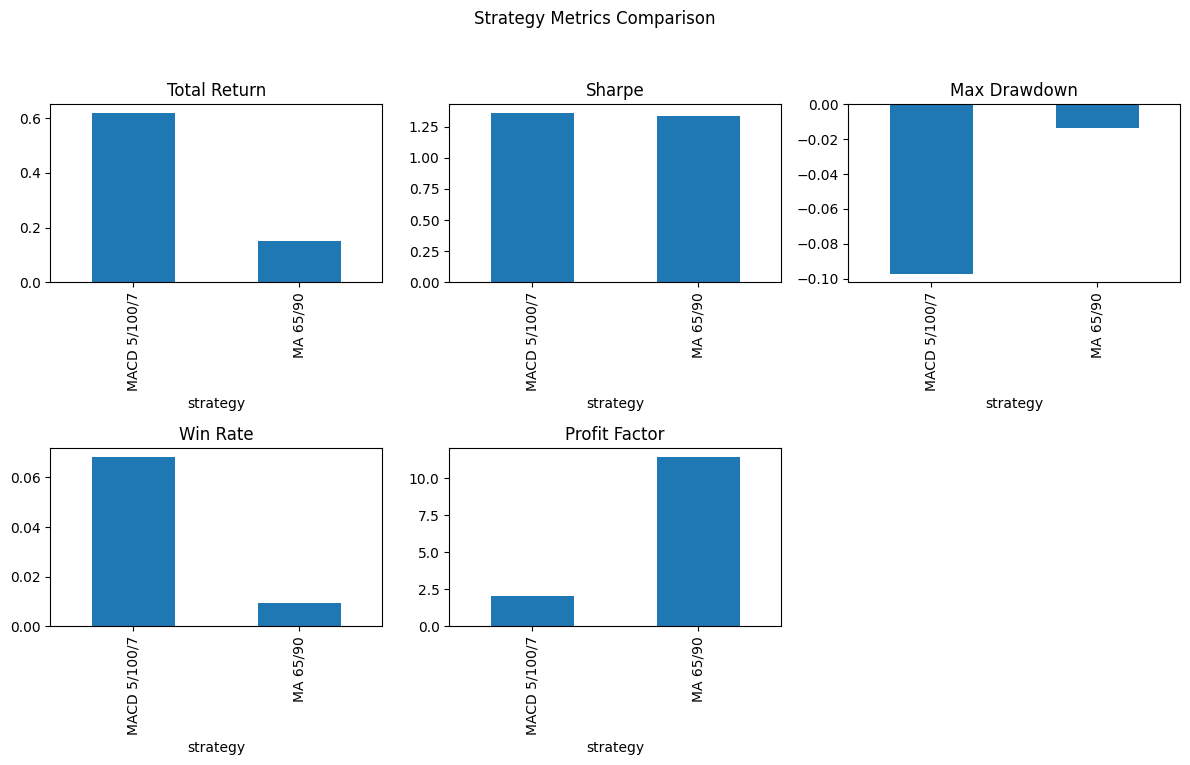

Overlaying equity curves...


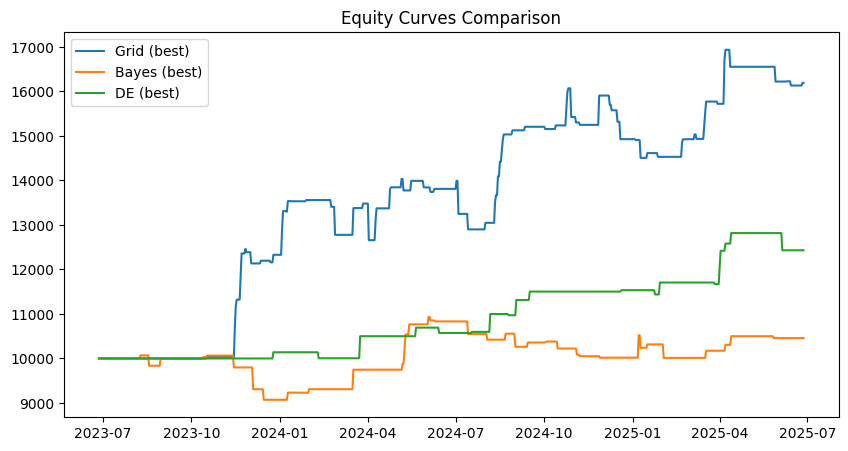

Combined Performance Report:
       Total Return  Ann. Return  Ann. Vol  Sharpe  Max Drawdown  Win Rate  Profit Factor  Expectancy
Grid         0.6194       0.1805    0.1280  1.3605       -0.0973    0.0683         2.0628     -0.0139
Bayes        0.0457       0.0155    0.0782  0.2358       -0.0990    0.0287         1.1807     -0.0165
DE           0.2431       0.0778    0.0586  1.3068       -0.0301    0.0178         4.2544     -0.0108
       Total Return  Ann. Return  Ann. Vol    Sharpe  Max Drawdown  Win Rate  \
Grid       0.619418     0.180523  0.127983  1.360474     -0.097333  0.068306   
Bayes      0.045728     0.015512  0.078207  0.235786     -0.099032  0.028689   
DE         0.243128     0.077800  0.058633  1.306771     -0.030134  0.017760   

       Profit Factor  Expectancy  
Grid        2.062830   -0.013947  
Bayes       1.180700   -0.016458  
DE          4.254408   -0.010798  


In [6]:
# 5) ReportManager plotting & saving
rm = ReportManager()
print("Plotting metrics for Grid best...")
rm.plot_metrics(perf_g)

# --- FIX: extract the single Series for each best equity curve ---
eq_series_g = eq_g[best_strat_g.name]
eq_series_b = eq_b[best_strat_b.name]
eq_series_d = eq_d[best_strat_d.name]

print("Overlaying equity curves...")
rm.plot_equity_curves({
    'Grid (best)':  eq_series_g,
    'Bayes (best)': eq_series_b,
    'DE (best)':    eq_series_d
})

# Compare and save
returns_g = eq_series_g.pct_change().fillna(0)
returns_b = eq_series_b.pct_change().fillna(0)
returns_d = eq_series_d.pct_change().fillna(0)

analyzers = {
    'Grid':  PerformanceAnalyzer(eq_series_g, returns_g),
    'Bayes': PerformanceAnalyzer(eq_series_b, returns_b),
    'DE':    PerformanceAnalyzer(eq_series_d, returns_d)
}

comp = rm.compare_performance(
    analyzers,
    save=True,
    report_name='full_demo_comparison'
)
print(comp)

In [16]:
# 6) TradingSystem Demo
print("\n=== TradingSystem Demo ===")
ts = TradingSystem('BTC-USD', DcaStrategy({'amount':500,'freq':'D'}), risk_manager=RiskManager('fixed', fixed_size=1))
ts.load(period='2y', interval='1d')
eq_ts = ts.run_backtest(save_report=True, initial_capital=10_000, do_print=True, report_name='ts_demo')
print(f"Final TS equity: {eq_ts.iloc[-1]:.2f}")


=== TradingSystem Demo ===
Performance Report (None):
Total Return     2.4966
Ann. Return      0.5387
Ann. Vol         0.4016
Sharpe           1.2728
Max Drawdown    -0.2814
Win Rate         0.5096
Profit Factor    1.2615
Expectancy       0.0020
Final TS equity: 34966.42


In [11]:
# 7) StrategyCollection Demo
grid_params = {'short_window': [5,10], 'long_window': [20,50]}
collection = StrategyCollection(strategy_cls=MovingAverageCrossStrategy, param_grid=grid_params)
eqs = collection.backtest_all('BTC-USD', period='2y', interval='1d')
print("Collection demos backtested strategies:", list(eqs.keys()))

Collection demos backtested strategies: ['MA 5/20', 'MA 5/50', 'MA 10/20', 'MA 10/50']


In [9]:
# 8) StrategyManager Demo
sm = StrategyManager()
strat_sample = MACDStrategy({'fast':12,'slow':26,'signal':9})
sm.save(strat_sample)
loaded = sm.load(strat_sample.name)
print("Loaded sample strategy:", loaded.name)

Loaded sample strategy: MACD 12/26/9


# END